# Cinética Química 
## Determinación de los parámetros cinéticos de una ecuación potencial:
## *Métodos diferencial e integral.*

In [2]:

#%matplotlib notebook

%matplotlib inline
import seaborn
import numpy as np
from scipy import optimize
from scipy.integrate import ode
import matplotlib.pyplot as mpl
import random
import math
import pandas as pd
import IPython.core.display as di
pd.set_option('display.notebook_repr_html', True)
from ipywidgets import interact
import notebook
from IPython.display import clear_output, display, HTML, Image,Math, Latex
from IPython.external import mathjax
FigureSize=(8,6)


def tiempo_final(Ca0):
    incr_t=0.05

    t = []
    Ca = []

    t.append(0)
    Ca.append(Ca0)

    r = ode(f).set_integrator('vode', method='bdf', nsteps=1000, atol = 1.0e-05, rtol = 1.0e-05)
    r.set_initial_value(Ca0,t[0]).set_f_params(n,k)
    #print(t[0], Ca[0])
    #print ('r_t: ',r.t,'Ca0: ',r.y)

    while r.successful() and Ca[-1]>0.05 and r.y>0:
        r.integrate(r.t + incr_t)
        #Ca[k1]=r.y
        Ca.append(r.y)
        t.append(r.t)
        #print ('tiempo:', '%.2f' % t[k], 'Ca:','%.4f'%Ca[k])


    return t[-1]


def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]


    results['correlation'] = correlation
    r_squared=correlation**2
    results['determination'] = correlation**2

    return r_squared,coeffs

def generador_parametros(): #generarción de parámetros de la ecuación cinética y Temperatura de trabajo
    global k, Ea, Ln_K0, n, T
    Ea=random.uniform(40.,80.0)
    Ln_K0 = random.uniform(15.,25.)
    T= random.uniform(40., 80.) #Temperatura en ºC
    T1=T+273.15 #Temperatura en K
    k = math.exp(Ln_K0)*math.exp(Ea*(-1000.)/(8.31*(T1)))

    n=round(random.uniform(0.5,2.05),2)
    return k,Ea,Ln_K0,n,T



def f(t,Ca,n,k): #ecuación cinética

    r=-1.*k*Ca**n
    return r





def generador_valores(n_ptos):
    global k, Ea, Ln_K0, n, T,incr_t
    k, Ea, Ln_K0, n, T = generador_parametros()

    #print (k, Ea, Ln_K0, n, T )

    Ca0=round(random.uniform(5.,10.),1)
    #print (Ca0)
    #intervalo de tiempo
    t_inicial=0.
    
    t_final=tiempo_final(Ca0)
    #t_final = random.uniform(30.,40.)*3600
    
    #print ('tiempo final: ',t_final)

    incr_t = (t_final - t_inicial) / n_ptos

    #print('t0: ', t_inicial, 'tf: ', t_final)
    num_pasos =int(np.floor((t_final - t_inicial) / incr_t)+1)

    #print ('incr_t: ',incr_t,'n_pasos: ',num_pasos)

    #t=np.array([])
    #Ca = np.array([])
    #crea vectores datos
    t = np.zeros(num_pasos)
    Ca = np.zeros(num_pasos)

    t[0] = t_inicial
    Ca[0] = Ca0

    r = ode(f).set_integrator('vode', method='bdf', nsteps=1000, atol = 1.0e-05, rtol = 1.0e-05)
    r.set_initial_value(Ca0,t_inicial).set_f_params(n,k)
    #print(t[0], Ca[0])
    #print ('r_t: ',r.t,'Ca0: ',r.y)
    k1=1
    while r.successful() and k1<num_pasos and r.y>=0:
        r.integrate(r.t + incr_t)
        #Ca[k1]=r.y
        Ca[k1] = r.y+random.uniform(-0.01,0.01)*r.y
        t[k1]=r.t
        #print ('tiempo:', '%.2f' % t[k], 'Ca:','%.4f'%Ca[k])
        k1+=1


    # odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0,
    #        ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0,
    #        hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12,
    #        mxords=5, printmessg=0)



    return t,Ca


def orden_1(Ca0,t,k2): #como entrada un valor y un arrays: concentración inicial y vector tiempo
    Ca=Ca0*np.exp(-k2*t)
    return Ca
#función n!=1
def orden_n(Ca0,t,n,k2): #como entrada un valor y un arrays: concentración inicial y vector tiempo
    #Ca = np.array([Ca0])
    Ln_Ca = (1 / (n + 1)) * np.log(-(n + 1) * k2 * t + Ca0 ** (n + 1))
    #Ca = np.append(Ca, np.exp(Ln_Ca))

    Ca = np.append(Ca0, np.exp(Ln_Ca))
    return Ca


def integral_1(param,x,y,Ca0): #param es la lista de parámetros a ajustar k:param[0]=Ln k
    # x e y son tuplas con los valores experimentales correspondientes. Cao es también una tupla con el valor del parámetro
    #Ca0, que se mantiene contante
    error_calculado=Ca0 * np.exp(-np.exp(param[0]) * x) - y
    return error_calculado


def integral_distinto1(param, x, y, Ca0):  # param es la lista de parámetros a ajustar n y k:param[0]=n, param[1]=Ln k
    # x e y son tuplas con los valores experimentales correspondientes. Cao es también una tupla con el valor del parámetro
    # Ca0, que se mantiene contante
    error_calculado = np.exp((1 / (param[0] + 1)) * np.log(-(param[0] + 1) * np.exp(param[1]) * x + Ca0 ** (param[0] + 1))) - y

    # error_calculado=1/(param[0]+1)*(np.log(-(param[0]+1)*np.exp(param[1])*x+Ca0**(param[0]+1)))-y
    return error_calculado

display(HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Mostrar código')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Esconder código')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Mostrar código"></form>'''))


display(HTML('<h1 style="color:#000000"><strong>Avanzar para generar datos</strong></h1>'))
display(HTML('<p>Recuerda cómo es una ecuación cinética potencial para:</br>  </p>' ))
display(Math(r'A \rightarrow B'))
display(Math(r'r=k\cdot C_A^n'))
display(HTML('<p>donde $r$ es la velocidad de reacción, $k$ es la constante cinética, \
                $C_A$ la concentración del reactivo A,\
             y $n$ es el orden de reacción.</br>  </p>' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
n_ptos=int(input("Nº de puntos: "))

while True:
    x,y=generador_valores(n_ptos)
    if x[-1]>=10 and x[-1]<=500:
        break
        
    


x1=np.copy(x)
x1= np.round(x1)
#x1.astype(np.int64)

y1=np.round(y,2)


data=dict()
data['tiempo (min)']=x1.tolist()
data['Concentración (mol/L)']=y1.tolist()


values = pd.DataFrame(data,columns=['tiempo (min)', 'Concentración (mol/L)'])
values.style.set_properties(**{'text-align': 'right'})
values.set_index('tiempo (min)',inplace=True)

#values['tiempo (min)'].astype(int)

display(values)


display(HTML('<h1 style="color:#000000""><strong>Avanzar para mostrar representación gráfica</strong></h1>'))

Nº de puntos: 10


,Concentración (mol/L)
tiempo (min),
0.0,8.50
11.0,2.39
22.0,1.02
33.0,0.55
44.0,0.33
55.0,0.21
66.0,0.15
77.0,0.11
88.0,0.08


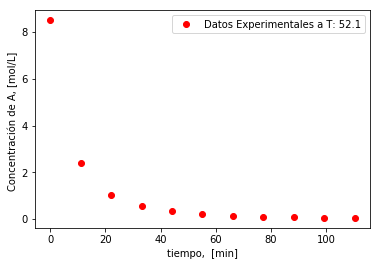

In [4]:
mpl.figure('figure1')


mpl.plot(x,y, 'ro',label = 'Datos Experimentales a T: '+str(round(T,1)))
mpl.xlabel('tiempo,  [min]')
mpl.ylabel('Concentración de A, [mol/L] ')
mpl.legend(loc = 'best')

mpl.show()

display(HTML('<h1 style="color:#000000"><strong>Avanzar para mostrar resultados\
            de aplicar el método diferencial</strong></h1>'))

In [ ]:
incr_ca=np.array([])
ca_med=np.array([])

for s, t in zip(y, y[1:]):
    if t==0:
        break
    dif=(t - s)
    ca_med=np.append(ca_med,(t+s)/2.)
    incr_ca =np.append(incr_ca,dif)



r=-(incr_ca/incr_t)


#Hay que eliminar los ceros para evitar errores al hacer el logaritmo

log_r=np.log(r)
log_caM=np.log(ca_med)

r_squared,coeffs=polyfit(log_caM, log_r,1)

n_diferencial=coeffs[0]
k_diferencial=math.exp(coeffs[1])
mpl.figure('figure2',figsize=FigureSize)


mpl.plot(log_caM,log_r, 'ro',label = 'Datos Experimentales')

estYVals = np.polyval(coeffs, log_caM)
mpl.plot(log_caM,estYVals, 'k-', linewidth = 1,label = '$\mathrm{R^2}$ = ' + str(round(r_squared, 3))
                                                   + ' Pendiente: ' + str(round(coeffs[0], 3))
                                                       + ' Ordenada: ' + str(round(coeffs[1], 3)))
mpl.xlabel('ln(Ca Medio),  [ ]')
mpl.ylabel('ln(r), [ ] ')
mpl.legend(loc = 'best')


mpl.show()

display(HTML('<h1 style="color:#000000"><strong>Avanzar para mostrar los resultados de aplicar el método integral </br>\
             empleando los parámetros cinéticos obtenidos anteriormente mediante el diferencial </strong></h1>'))

In [ ]:
x1=np.delete(x,[0])
if  0.98<=n_diferencial<=1.03:
    y1=orden_1(y[0],x,k_diferencial)
else:
    y1 = orden_n(y[0], x1,-n_diferencial,k_diferencial)

#print (x,'\n \n',x1, '\n \n',y1,'\n \n',y)



mpl.figure('figure3',figsize=FigureSize)

mpl.plot(x,y, 'ro',label = 'Datos Experimentales a T: '+str(round(T,1)))
mpl.plot(x,y1, linestyle='solid', linewidth=1, color='black',label = 'Datos predicthos a n=: '+str(round(n_diferencial,2)))
mpl.xlabel('tiempo,  [min]')
mpl.ylabel('Concentración de A, [mol/L] ')
mpl.legend(loc = 'best')
mpl.show()



mse=sum((y-y1)**2)
print ('MSE: ',mse)

display(HTML('<h1 style="color:#000000"><strong>Avanzar para ajustar los datos experimentales a una ecuación dependiendo\
de si:</strong></h1>'))
display(Math(r'n=1 \textrm{ o }  n\neq 1'))


In [ ]:
orden_reaccion=input("¿n=1?(s/n): ")

if orden_reaccion==s:
    x0 = np.array(np.log(k)) # Valores iniciales de los parámetros
    resultados_optimizacion = optimize.least_squares(integral_1, x0, args=(x, y, y[0]))
else:
    # Valores iniciales de los parámetros
    x0 = np.array([np.log(n), np.log(k)])
    resultados_optimizacion = optimize.least_squares(integral_distinto1, x0, args=(x, y, y[0]))


parametros_cal=resultados_optimizacion.x

#print (resultados_optimizacion.status, resultados_optimizacion.success)

if orden_reaccion==s:
    y1_integral=y[0] * np.exp(-np.exp(parametros_cal[0]) * x)
else:
    y1_integral = np.exp((1 / (parametros_cal[0] + 1)) * np.log(-(parametros_cal[0] + 1) \
                                            * np.exp(parametros_cal[1]) * x + y[0] ** (parametros_cal[0] + 1)))

mpl.figure('figure4',figsize=FigureSize)
mpl.plot(x,y, 'ro',label = 'Datos Experimentales a T: '+str(round(T,1)))
mpl.plot(x,y1_integral, linestyle='solid', linewidth=1, color='black',label = 'Datos predichos')
mpl.xlabel('tiempo,  [min]')
mpl.ylabel('Concentración de A, [mol/L] ')
mpl.legend(loc = 'best')

mpl.show()



if orden_reaccion==s:
    print ('Resultados optimización: Ln k:','%.3f' % resultados_optimizacion.x[0])
else:
    n_optimizacion=-resultados_optimizacion.x[0]
    print ('Resultados optimización: Ln k:','%.3f' % resultados_optimizacion.x[1],' n: ', '%.2f' % n_optimizacion)                                                              
mse=sum(resultados_optimizacion.fun**2)
print ('MSE: ',mse)


In [ ]:

display(HTML('<h3 style="color:#000000"><strong>Valores empleados para generar los datos: valores "reales"</strong></h3>'))
print ("Ln k: ",'%.3f' % math.log(k), " n: ", '%.2f' % n)

In [ ]:
display(HTML('''

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Programado con Jupyter Notebook en Python 3.6. </footer>'''))